<a href="https://colab.research.google.com/github/changhorang/SSAC_study/blob/main/DL/08_2_CNN_Image_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN   small datasets 학습


- 학습할 Data의 개수가 많지 않을 때 CNN을 통한 모형 학습이 어려울 수 있음
  - 딥러닝은 많은 수의 데이터를 통해 feature engineering 과정 없이 원하는 문제를 해결할 수 있다. => **Point: 많은 데이터 수**
- Data가 많지 않아 CNN 학습에 어려움이 있을 때 사용 가능한 방법
    - Data augmentation 활용
        - 원본 이미지의 색깔, 각도 등을 약간씩 변형한 이미지들을 추가로 만들어 data의 수를 늘림 
    - Pre-trained network의 활용
        - 매우 큰 데이터셋으로 미리 Training한 모델의 파라미터(가중치)를 가져와서 풀려는 문제에 맞게 모델을 재보정해서 사용한다.
        - 성능이 좋은 학습된 모델을 사용하므로 적은 데이터에도 좋은 성능을 낼 수있다.

## Data for cats vs. dogs
- 2013년 Kaggle의 computer vision competition data 활용 https://www.kaggle.com/c/dogs-vs-cats/data
- 개와 고양이를 구분하기 위한 문제로 각 12,500개의 이미지를 포함
- Medium-resolution color JPEGs
- 25000장의 사진 중 4000장의 cats/dogs 사진(2000 cats, 2000 dogs) 만을 사용하여 학습하여 좋은 모형을 만들어 낼 수 있을까?
    - 학습: 2000, 검증: 1000, 테스트: 1000
    
![cats_vs_dogs_samples](https://s3.amazonaws.com/book.keras.io/img/ch5/cats_vs_dogs_samples.jpg)

##### 이미지 다운로드
- gdown 패키지 : 구글 드라이브의 공유파일 다운로드 패키지    
- `pip install gdown==3.3.1`
- 코랩에는 설치 되어 있음.

In [1]:
import gdown

url = 'https://drive.google.com/uc?id=1nBE3N2cXQGwD8JaD0JZ2LmFD-n3D5hVU'
fname = 'cats_and_dogs_small.zip'

gdown.download(url, fname, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1nBE3N2cXQGwD8JaD0JZ2LmFD-n3D5hVU
To: /content/cats_and_dogs_small.zip
100%|██████████| 90.8M/90.8M [00:00<00:00, 149MB/s]


'cats_and_dogs_small.zip'

In [2]:
import os
from zipfile import ZipFile

# ZipFile(압축파일경로).extractall(압축풀경로)
ZipFile(fname).extractall(os.path.join('data','cats_and_dogs_small'))

In [ ]:
# 리눅스 명령어로 zip 파일 풀기
# unzip 압축파일명 -d 풀디렉토리
# unzip cats_and_dogs_small.zip -d data/c_d_s

# 하이퍼파라미터 정의

In [23]:
LEARNING_RATE = 0.001
N_EPOCHS = 100
N_BATCHS = 32

IMAGE_SIZE = 224

# ImageDataGenerator 생성

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [25]:
train_dir = "data/cats_and_dogs_small/train"
valid_dir = "data/cats_and_dogs_small/validation"
test_dir = "data/cats_and_dogs_small/test"

In [6]:
# ImageDataGenerator를 생성 -> image augmentation은 적용안함. scaling만 적용
train_datagen = ImageDataGenerator(rescale=1/255.0)
valid_datagen = ImageDataGenerator(rescale=1/255.0)
test_datagen = ImageDataGenerator(rescale=1/255.0)

In [7]:
# ImageDataGenerator에 raw data를 연결
# flow_from_directory() : 디렉토리로 부터 직접 읽어 오는 방식
train_iter = train_datagen.flow_from_directory(train_dir, # image가 있는 디렉토리, 하위 디렉토리 -> label
                                               target_size=(IMAGE_SIZE, IMAGE_SIZE), # resize : (h, w)
                                               class_mode='binary', # output(y)의 형태 - 2진분류: binary, 다중: catecory (ohe), sparse (label encoding)
                                               batch_size=N_BATCHS # 한 번에 제공할 데이터(이미지) 개수
                                               )

valid_iter = valid_datagen.flow_from_directory(valid_dir, target_size=(IMAGE_SIZE, IMAGE_SIZE), 
                                               class_mode='binary', batch_size=N_BATCHS)

test_iter = test_datagen.flow_from_directory(test_dir, target_size=(IMAGE_SIZE, IMAGE_SIZE), 
                                              class_mode='binary', batch_size=N_BATCHS)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [9]:
# label확인
train_iter.class_indices, valid_iter.class_indices, test_iter.class_indices 

({'cats': 0, 'dogs': 1}, {'cats': 0, 'dogs': 1}, {'cats': 0, 'dogs': 1})

In [ ]:
# 1 epoch당 step 수 (몇 번 데이터를 제공하는지, 전체 데이터를 batch_size 만큼 제공할 때 몇 번만에 제공)
len(train_iter), len(valid_iter), len(test_iter)

In [10]:
# iterator를 이용해서 데이터를 조회
batch = next(train_iter) # 반환 타입 : tuple (image, label)
print(type(batch))
print(type(batch[0]), type(batch[1]))
print(batch[0].shape, batch[1].shape)
# (32, 244, 244, 3) : (batch_size, height, width, channel) h/w : 244 (resize된 크기)

<class 'tuple'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(32, 224, 224, 3) (32,)


In [11]:
batch[1][:10] # label 10확인. 1: dogs, 0: cats

array([0., 0., 0., 0., 0., 1., 0., 1., 0., 0.], dtype=float32)

In [12]:
# image 1장 확인
# pixel들의 최대/최소 값 확인
import numpy as np
np.min(batch[0][0]), np.max(batch[0][0])

(0.0, 1.0)

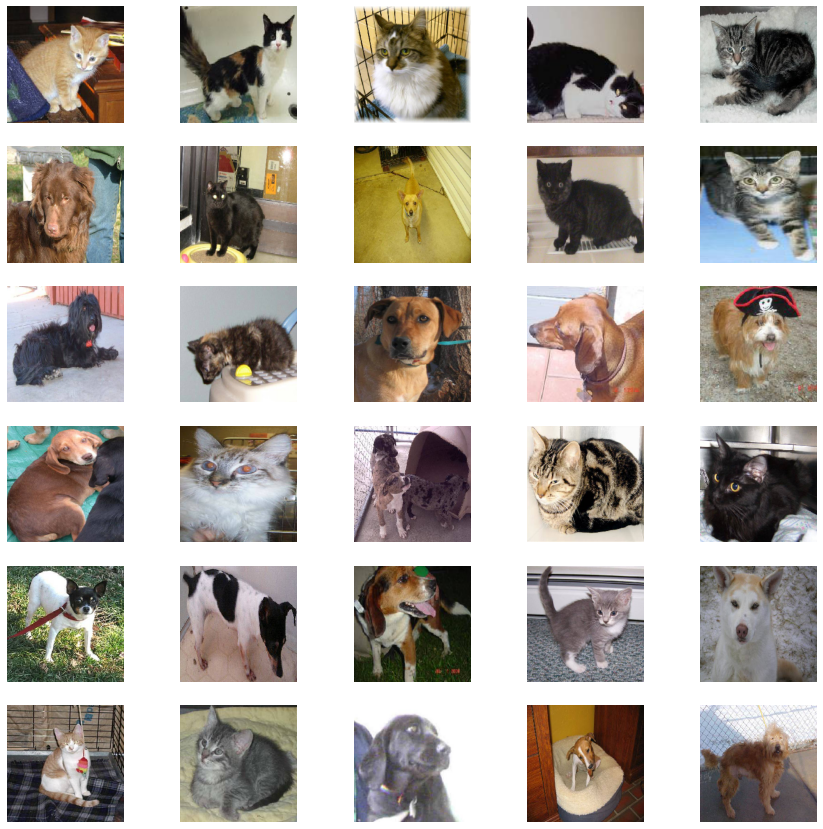

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 15))
for i in range(30):
  plt.subplot(6, 5, i+1)
  plt.imshow(batch[0][i])
  plt.axis('off')
plt.show()

## 모델 구현 및 학습

- Input: $224 \times 224$ 픽셀의 RGB layer 
- Output: cat or dog (binary classification)  
- ImageDataGenerator를 이용해 파일시스템에 저장된 이미지 데이터셋을 학습시킨다.

In [26]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 

import numpy as np

In [27]:
def create_model():
    model = keras.Sequential()
    
    model.add(layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
    model.add(layers.MaxPool2D(padding="same"))

    model.add(layers.Conv2D(filters=64, kernel_size=3, padding="same", activation='relu'))
    model.add(layers.MaxPool2D(padding='same'))

    model.add(layers.Conv2D(filters=128, kernel_size=3, padding="same", activation='relu'))
    model.add(layers.MaxPool2D(padding='same'))

    model.add(layers.Conv2D(filters=128, kernel_size=3, padding="same", activation='relu'))
    model.add(layers.MaxPool2D(padding='same'))

    
    model.add(layers.Flatten())
    
    model.add(layers.Dropout(rate=0.5))
    model.add(layers.Dense(units=512, activation='relu'))
    model.add(layers.Dense(units=1, activation='sigmoid'))
    # 2진분류 출력: unit=1, activation=sigmoid => 0 or 1일 확률

    return model

In [23]:
model = create_model()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 128)      0

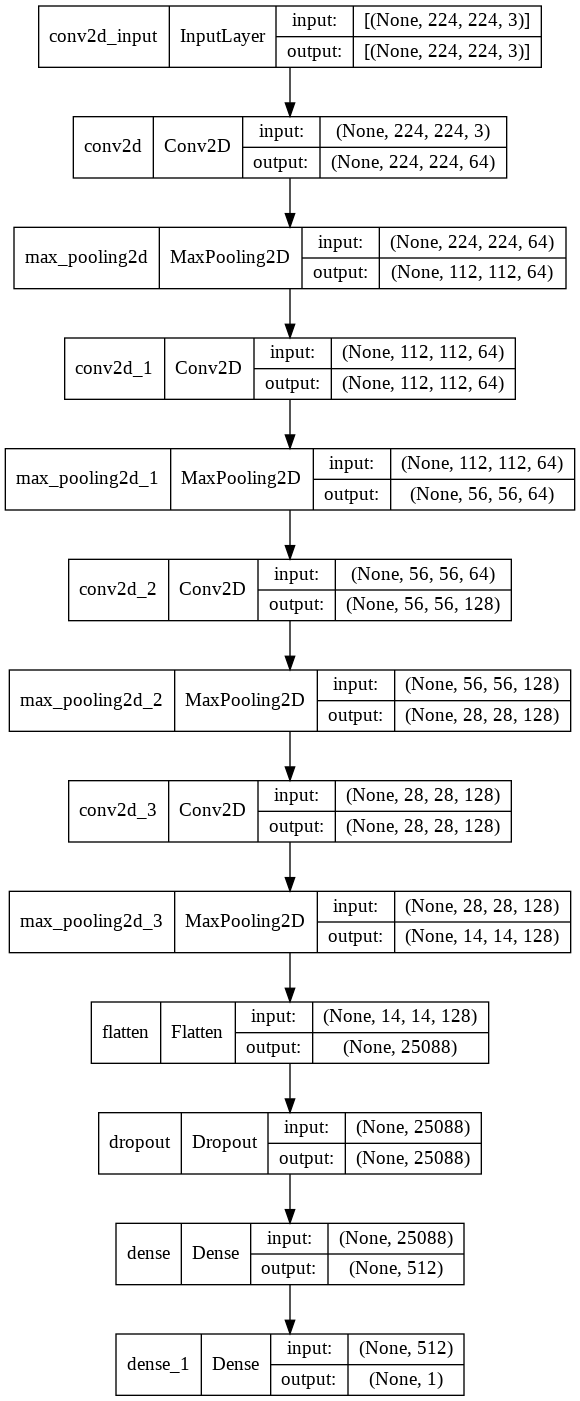

In [25]:
keras.utils.plot_model(model, show_shapes=True)


##  Model Training(학습)

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
import os
save_dir = os.path.join("/content/drive/MyDrive/DL", "cat_dog_model", "basic")
print(save_dir)
os.makedirs(save_dir, exist_ok=True) # exist_ok=True: 이미 있는 디렉토리면 무시 ([default]: False)

/content/drive/MyDrive/deeplearning/cat_dog_model/basic


In [30]:
save_file_path = os.path.join(save_dir, "weights_ckpt")
# 학습중 모델을 저장하는 callback - best_model, weights(parameter)만 저장
mc_callback = keras.callbacks.ModelCheckpoint(filepath=save_file_path, 
                                              save_weights_only=True, # weight만 저장
                                              save_best_only=True, 
                                              monitor='val_loss', 
                                              verbose=2)

# 학습중 성능이 개선되지 않으면 학습을 멈추도록하는 callback
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", 
                                            patience=10,
                                            verbose=1)

In [31]:
# ImageDataGenerator를 사용해 학습할 경우, steps_per_epoch, validation_steps 계산 필요
# steps_per_epoch: train dataset에 대해 1에폭당 step 수
# validation_steps: validation dataset에 대해서 1에폭당 step 수 
hist = model.fit(train_iter, 
                 epochs=N_EPOCHS, 
                 steps_per_epoch=len(train_iter),
                 validation_data=valid_iter, 
                 validation_steps=len(valid_iter),
                 callbacks=[mc_callback, es_callback])

Epoch 1/100
63/63 [==============================] - ETA: 0s - loss: 0.7050 - accuracy: 0.5135
Epoch 00001: val_loss improved from inf to 0.69316, saving model to /content/drive/MyDrive/deeplearning/cat_dog_model/basic/weights_ckpt
63/63 [==============================] - 27s 261ms/step - loss: 0.7050 - accuracy: 0.5135 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.4995
Epoch 00002: val_loss did not improve from 0.69316
63/63 [==============================] - 15s 233ms/step - loss: 0.6932 - accuracy: 0.4995 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/100
63/63 [==============================] - ETA: 0s - loss: 0.6927 - accuracy: 0.5215
Epoch 00003: val_loss improved from 0.69316 to 0.69252, saving model to /content/drive/MyDrive/deeplearning/cat_dog_model/basic/weights_ckpt
63/63 [==============================] - 15s 240ms/step - loss: 0.6927 - accuracy: 0.5215 - val_loss: 0.6925 - val_accurac

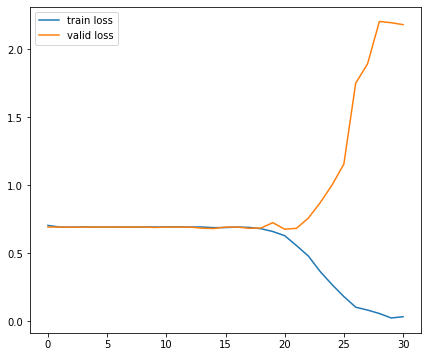

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,6))
plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='valid loss')
plt.legend()
plt.show()

##### 저장된 모델 조회

In [33]:
save_model = create_model()
save_model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

In [34]:
save_model.evaluate(test_iter) # weight loading 하기 전에 평가

32/32 [==============================] - 4s 128ms/step - loss: 0.6926 - accuracy: 0.4970


[0.6925700306892395, 0.4970000088214874]

In [35]:
save_model.load_weights(save_file_path) # 학습된 weight를 덮어쓰기 (loading)

In [36]:
save_model.evaluate(test_iter) # [loss, accuracy] : [0.6954858303070068, 0.6110000014305115]

32/32 [==============================] - 4s 127ms/step - loss: 0.6955 - accuracy: 0.6110


[0.6954858303070068, 0.6110000014305115]

# 새로운 데이터 추론

In [28]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_preprocess_image(img_path):
    """
    img_path 이미지를 읽어서 추론할 수있는 ndarray로 변환해서 반환하는 함수
    1. image read
    2. ndarray transform
    3. reshape (4d) (num, h, w, c)
    """
    
    raw_img = load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE)) # target_size 지정: 읽어올 때 이미지 사이즈 지정
    img_array = img_to_array(raw_img)
    img_array = img_array[np.newaxis, ...]
    return (img_array/255.0).astype(np.float32) # scaling해서 반환

In [39]:
dog = load_preprocess_image('dog.jpg')
cat = load_preprocess_image('cat.jpg')
dog.shape, cat.shape

((1, 224, 224, 3), (1, 224, 224, 3))

In [40]:
pred1 = save_model.predict(dog)
pred2 = save_model.predict(cat)

In [41]:
print(pred1)
result1 = np.where(pred1>0.5, 1, 0)[0]
result1

[[0.9345314]]


array([1])

In [42]:
print(pred2)
result2 = np.where(pred2>0.5, 1, 0)[0]
result2

[[0.9212183]]


array([1])

In [43]:
train_iter.class_indices

{'cats': 0, 'dogs': 1}

# Using data augmentation

- 학습 이미지의 수가 적어서 overfitting이 발생할 가능성을 줄이기 위해 기존 훈련 데이터로부터 그럴듯하게 이미지 변환을 통해서 이미지(데이터)를 늘리는 작업을 Image augmentation
- train_set에만 적용, validation, test set에는 적용하지 않는다. (rescaling만 한다.)

In [ ]:
import gdown

url = 'https://drive.google.com/uc?id=1nBE3N2cXQGwD8JaD0JZ2LmFD-n3D5hVU'
fname = 'cats_and_dogs_small.zip'

gdown.download(url, fname, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1nBE3N2cXQGwD8JaD0JZ2LmFD-n3D5hVU
To: /content/cats_and_dogs_small.zip
100%|██████████| 90.8M/90.8M [00:00<00:00, 205MB/s]


'cats_and_dogs_small.zip'

In [ ]:
import os
from zipfile import ZipFile

# ZipFile(압축파일경로).extractall(압축풀경로)
ZipFile(fname).extractall(os.path.join('data','cats_and_dogs_small'))

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

np.random.seed(0)
tf.random.set_seed(0)

##### 하이파러파미터

In [2]:
LEARNING_RATE = 0.001
N_EPOCHS = 100
N_BATCHS = 80

IMAGE_SIZE = 224

##### ImageDataGenerator 생성

In [3]:
train_dir = 'data/cats_and_dogs_small/train'
valid_dir = 'data/cats_and_dogs_small/validation'
test_dir = 'data/cats_and_dogs_small/test'

In [4]:
train_datagen = ImageDataGenerator(rescale=1/255.0,        # scaling: 0 ~ 1
                                   rotation_range=40,      # rotation: -40 ~ 40
                                   width_shift_range=0.2,  # 좌우 이동: -0.2 ~ 0.2
                                   height_shift_range=0.2, # 상하 이동: -0.2 ~ 0.2
                                   shear_range=0.2,        # 전단 변환: -0.2 ~ 0.2
                                   zoom_range=0.2,         # 확대&축소: 0.8 ~ 1.2
                                   horizontal_flip=True,   # 좌우 반전
                                   fill_mode='constant'    # 변환 후 생기는 공백 픽셀을 0으로 채우기
                                   )

valid_datagen = ImageDataGenerator(rescale=1/255.0)
test_datagen = ImageDataGenerator(rescale=1/255.0)


In [11]:
train_iter = train_datagen.flow_from_directory(train_dir, target_size=(IMAGE_SIZE, IMAGE_SIZE), 
                                               class_mode='binary', batch_size=N_BATCHS)

valid_iter = valid_datagen.flow_from_directory(valid_dir, target_size=(IMAGE_SIZE, IMAGE_SIZE), 
                                               class_mode='binary', batch_size=N_BATCHS)

test_iter = test_datagen.flow_from_directory(test_dir, target_size=(IMAGE_SIZE, IMAGE_SIZE), 
                                                class_mode='binary', batch_size=N_BATCHS)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [12]:
batch_samples = next(train_iter)
print(type(batch_samples)) # (X_image, y_label)

<class 'tuple'>


In [13]:
batch_image_sample = batch_samples[0]
batch_image_sample.shape, batch_image_sample.dtype

((80, 224, 224, 3), dtype('float32'))

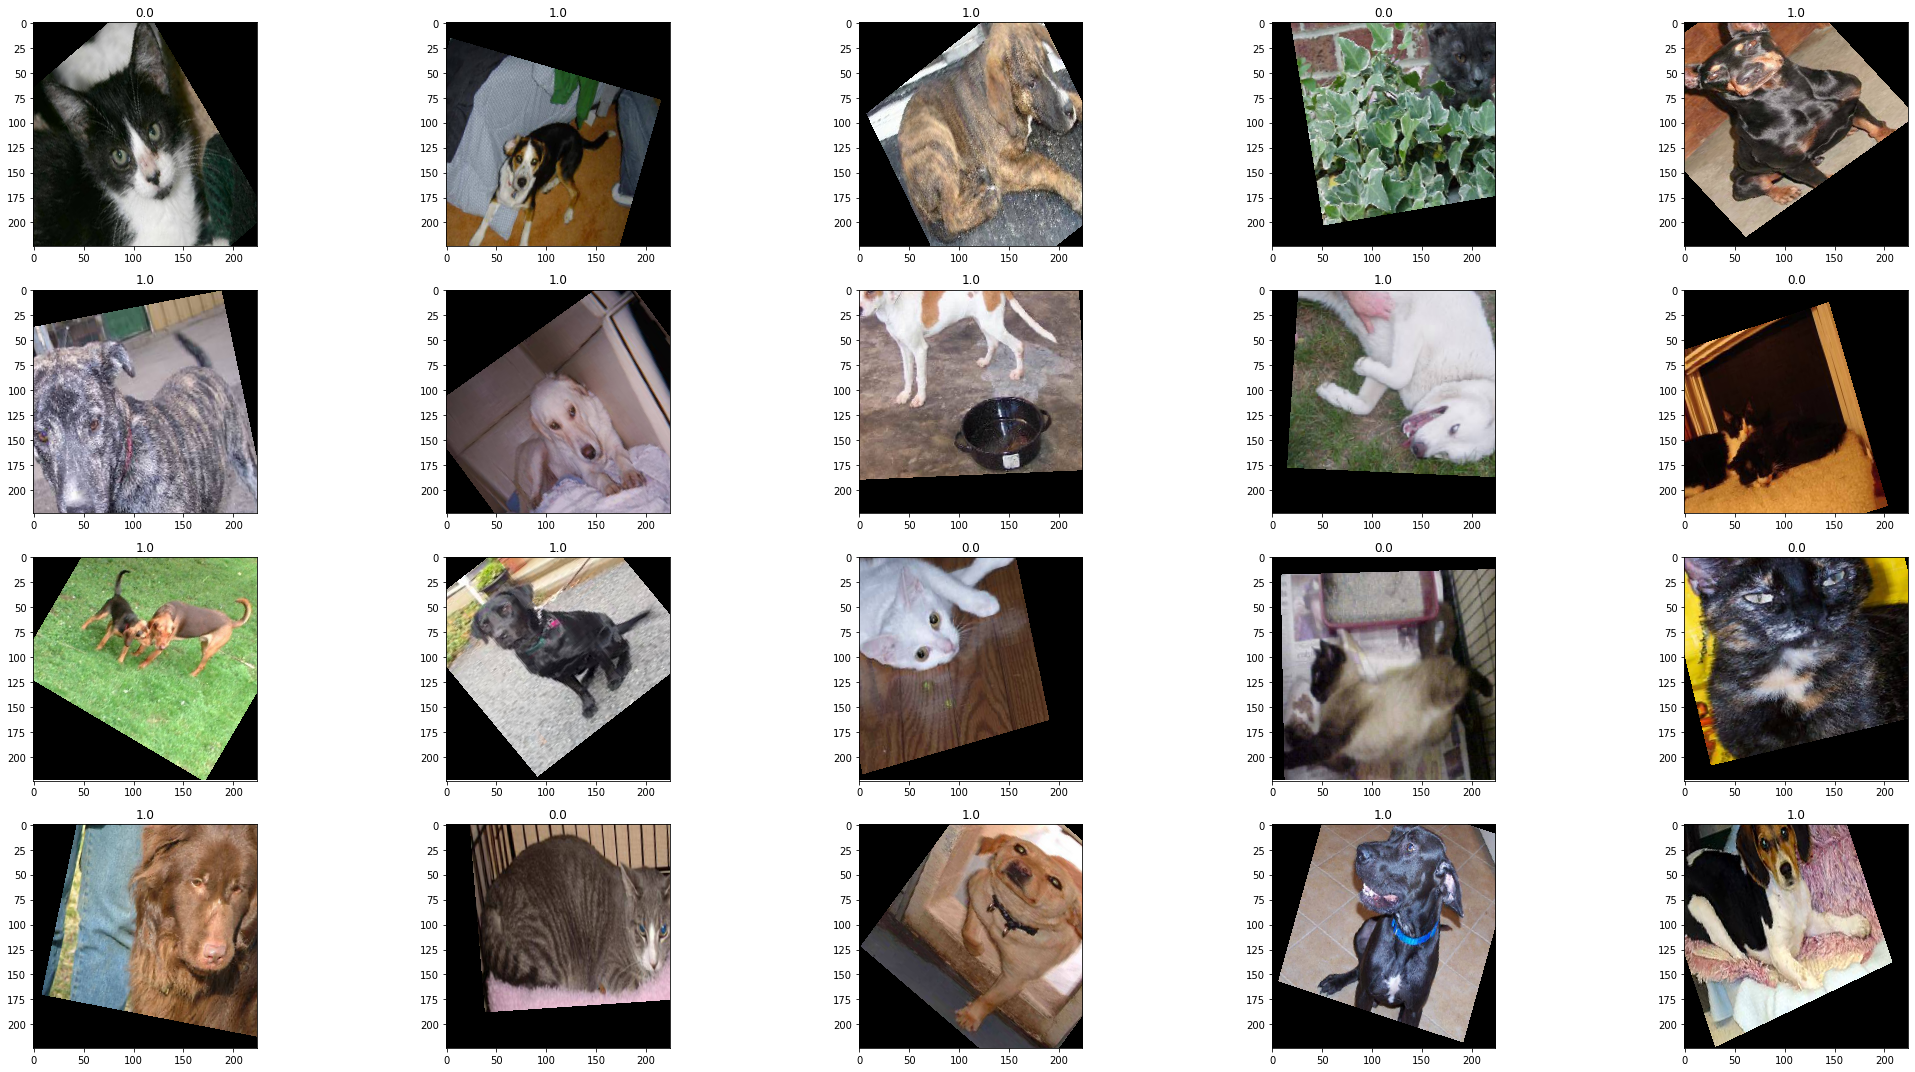

In [15]:
# iterator가 제공한 이미지들을 확인 (augmentation이 적용된 이미지들)
plt.figure(figsize=(30,15))
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.imshow(batch_image_sample[i])
    plt.title(str(batch_samples[1][i]))

plt.tight_layout()
plt.show()

##### 모델 생성, 컴파일, 학습

In [17]:
model = create_model()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
              loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
save_dir = os.path.join("/content/drive/MyDrive/DL/saved_models/cat_dog_model", "augmentation")
os.makedirs(save_dir, exist_ok=True)

In [19]:
save_file_path = os.path.join(save_dir, 'weights_ckpt')

mc_callback = keras.callbacks.ModelCheckpoint(filepath=save_file_path, 
                                              save_weights_only=True, 
                                              save_best_only=True, 
                                              monitor='val_loss', 
                                              verbose=2)

es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=2)

In [20]:
hist = model.fit(train_iter, epochs=N_EPOCHS, steps_per_epoch=len(train_iter), 
                 validation_data=valid_iter, validation_steps=len(valid_iter),
                 callbacks=[mc_callback, es_callback])

Epoch 1/100
25/25 [==============================] - ETA: 0s - loss: 0.7167 - accuracy: 0.4930
Epoch 00001: val_loss improved from inf to 0.69253, saving model to /content/drive/MyDrive/DL/cat_dog_model/augmentation/weights_ckpt
25/25 [==============================] - 45s 1s/step - loss: 0.7167 - accuracy: 0.4930 - val_loss: 0.6925 - val_accuracy: 0.5000
Epoch 2/100
25/25 [==============================] - ETA: 0s - loss: 0.6933 - accuracy: 0.5005
Epoch 00002: val_loss did not improve from 0.69253
25/25 [==============================] - 31s 1s/step - loss: 0.6933 - accuracy: 0.5005 - val_loss: 0.6942 - val_accuracy: 0.5000
Epoch 3/100
25/25 [==============================] - ETA: 0s - loss: 0.6939 - accuracy: 0.4790
Epoch 00003: val_loss did not improve from 0.69253
25/25 [==============================] - 30s 1s/step - loss: 0.6939 - accuracy: 0.4790 - val_loss: 0.6927 - val_accuracy: 0.4990
Epoch 4/100
25/25 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.50

##### 저장된 모델 Loading 후 평가(사용)

In [22]:
saved_model_aug = create_model()
saved_model_aug.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy', metrics=['accuracy'])

save_file_path = '/content/drive/MyDrive/DL/saved_models/cat_dog_model/augmentation/weights_ckpt'
saved_model_aug.load_weights(save_file_path)

In [23]:
saved_model_aug.evaluate(test_iter)

13/13 [==============================] - 4s 277ms/step - loss: 0.6850 - accuracy: 0.5070


[0.6849871277809143, 0.5070000290870667]

##### 새로운데이터 추론

In [25]:
dog2 = load_preprocess_image('dog.jpg')
cat2 = load_preprocess_image('cat.jpg')

pred3 = saved_model_aug.predict(dog2)
pred4 = saved_model_aug.predict(cat2)

In [26]:
pred3

array([[0.58920306]], dtype=float32)

In [27]:
pred4

array([[0.56852233]], dtype=float32)

###  DataFrame 이용
- flow_from_dataframe() 사용
    - 파일경로와 label을 DataFrame으로 저장하고 그것을 이용해 데이터셋을 읽어온다.

In [1]:
import gdown
url = 'https://drive.google.com/uc?id=17ejPJw42TgTv0jCPMMlVTHwF57XYE2kb'
fname = 'cats_and_dogs_union.zip'
gdown.download(url, fname, quiet=True)

'cats_and_dogs_union.zip'

In [2]:
import os
from zipfile import ZipFile

ZipFile(fname).extractall(os.path.join('data','union'))

# 파일경로와 Label 정의한 DataFrame 생성
- 두 개컬럼 (파일경로-path, 라벨-label)

In [ ]:
from glob import glob
# 특정 디렉토리 아래 있는 "모든 파일"이나 이름의 "어떤 조건의 파일"들의 경로를 조회할 때 사용
# glob(r'/content/data/union/cats/*.*') # 모든 파일
# glob(r'/content/data/union/cats/*.jpg') # 확장자가 jpg인 파일들
# glob(r'/content/data/union/cats/cat.2*.jpg') # 이름 cat.2로 시작 & 확장자가 jpg인 파일들
glob(r'/content/data/union/**/*.jpg') # union의 하위 디렉토리에 있는 모든 jpg

# 파일의 경로를 주면 있는 파일일 경우 경로를 반환

In [8]:
# os 모듈의 함수를 이용해서 파일 경로에서 특정 문자열(디렉토리명, 파일명)을 추출
f = '/content/data/union/cats/cat.791.jpg' # file 경로 1개

# string split
l = f.split('.')[-1]
l

'jpg'

In [10]:
os.path.basename(f) # 전체 경로(path)에서 마지막 경로만 추출 'a/b/c/d -> d'

'cat.791.jpg'

In [11]:
os.path.dirname(f) # 전체 경로(path)에서 디렉토리 경로만 추출 (마지막 경로 앞까지 추출)
# 'a/b/c/d -> a/b/c'

'/content/data/union/cats'

In [12]:
# 파일 경로에서 label을 추출
# directory
dir_name = os.path.dirname(f)
dir_name.split('/')[-1]

'cats'

In [14]:
# 파일명에서 label을 추출
# label.num.jpg
file_name = os.path.basename(f)
file_name.split('.')[0]

'cat'

In [3]:
# glob: 파일의 경로를 추출하는 모듈
#     : 패턴 문자를 이용해 여러 파일들의 경로를 쉽게 추출할 수 있음
#     directory: ** - 모든 하위 디렉토리를 의미
#     file : * - 모든 글자
from glob import glob
path_list = glob('/content/data/union/**/*.jpg')
type(path_list)

list

In [4]:
path_list[:10]

['/content/data/union/dogs/dog.977.jpg',
 '/content/data/union/dogs/dog.1809.jpg',
 '/content/data/union/dogs/dog.460.jpg',
 '/content/data/union/dogs/dog.908.jpg',
 '/content/data/union/dogs/dog.1582.jpg',
 '/content/data/union/dogs/dog.330.jpg',
 '/content/data/union/dogs/dog.1902.jpg',
 '/content/data/union/dogs/dog.186.jpg',
 '/content/data/union/dogs/dog.1281.jpg',
 '/content/data/union/dogs/dog.1697.jpg']

In [5]:
label_list = []
for path in path_list:
    label = os.path.basename(path).split('.')[0] # 파일명에서 label 추출
    label_list.append(label)

In [6]:
label_list[-10:], len(label_list)

(['cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat'], 4000)

In [7]:
label_list2 = [os.path.basename(path).split('.')[0] for path in path_list]
label_list2[:10], len(label_list2)

(['dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog'], 4000)

In [8]:
import pandas as pd
d = {
    'path':path_list,
    'label':label_list
}
df = pd.DataFrame(d)
df.shape

(4000, 2)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    4000 non-null   object
 1   label   4000 non-null   object
dtypes: object(2)
memory usage: 62.6+ KB


In [10]:
df.describe()

,path,label
count,4000,4000
unique,4000,2
top,/content/data/union/cats/cat.1435.jpg,cat
freq,1,2000


In [11]:
df['label'].value_counts()

cat    2000
dog    2000
Name: label, dtype: int64

In [12]:
df.head()

,path,label
0,/content/data/union/dogs/dog.977.jpg,dog
1,/content/data/union/dogs/dog.1809.jpg,dog
2,/content/data/union/dogs/dog.460.jpg,dog
3,/content/data/union/dogs/dog.908.jpg,dog
4,/content/data/union/dogs/dog.1582.jpg,dog


In [13]:
df.tail()

,path,label
3995,/content/data/union/cats/cat.1673.jpg,cat
3996,/content/data/union/cats/cat.1510.jpg,cat
3997,/content/data/union/cats/cat.1610.jpg,cat
3998,/content/data/union/cats/cat.1430.jpg,cat
3999,/content/data/union/cats/cat.664.jpg,cat


In [14]:
df.to_csv('cat_dog_path.csv', index=False)

# train/test/validation set으로 나누기.

In [15]:
cat_df = df[df['label']=='cat']

dog_df = df[df['label']=='dog']
cat_df.shape, dog_df.shape

((2000, 2), (2000, 2))

In [16]:
print(cat_df['label'].value_counts())
dog_df['label'].value_counts()

cat    2000
Name: label, dtype: int64


dog    2000
Name: label, dtype: int64

In [17]:
idx = 1600
train_df = pd.concat([cat_df.iloc[:idx], dog_df.iloc[:idx]], axis=0)

test_df = pd.concat([cat_df.iloc[idx:], dog_df.iloc[idx:]], axis=0)

train_df.shape, test_df.shape

((3200, 2), (800, 2))

In [18]:
train_df['label'].value_counts()

cat    1600
dog    1600
Name: label, dtype: int64

In [19]:
test_df['label'].value_counts()

cat    400
dog    400
Name: label, dtype: int64

In [20]:
train_df.to_csv('cat_dog_path_train.csv', index=False)
test_df.to_csv('cat_dog_path_test.csv', index=False)

In [21]:
train_df.head()

,path,label
2000,/content/data/union/cats/cat.953.jpg,cat
2001,/content/data/union/cats/cat.1488.jpg,cat
2002,/content/data/union/cats/cat.280.jpg,cat
2003,/content/data/union/cats/cat.1018.jpg,cat
2004,/content/data/union/cats/cat.243.jpg,cat


In [22]:
train_df.tail()

,path,label
1595,/content/data/union/dogs/dog.1937.jpg,dog
1596,/content/data/union/dogs/dog.1132.jpg,dog
1597,/content/data/union/dogs/dog.1646.jpg,dog
1598,/content/data/union/dogs/dog.962.jpg,dog
1599,/content/data/union/dogs/dog.253.jpg,dog


# ImageDataGenerator 생성

In [29]:
train_datagen = ImageDataGenerator(rescale=1/255.0, 
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True,
                                   brightness_range=[0.7, 1.3],
                                   fill_mode='constant')

valid_datagen = ImageDataGenerator(rescale=1/255.0)

In [30]:
train_iter = train_datagen.flow_from_dataframe(train_df,      # 경로/라벨이 있는 dataframe객체
                                               x_col="path",  # 경로 컬럼명
                                               y_col='label', # label 컬럼명
                                               class_mode='binary',
                                               target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                               batch_size=N_BATCHS)

valid_iter = valid_datagen.flow_from_dataframe(test_df,
                                               x_col="path",
                                               y_col='label',
                                               class_mode='binary',
                                               target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                               batch_size=N_BATCHS)

Found 3200 validated image filenames belonging to 2 classes.
Found 800 validated image filenames belonging to 2 classes.


In [31]:
train_iter.class_indices

{'cat': 0, 'dog': 1}

##### 모델 생성, 컴파일

In [32]:
model = create_model()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy', metrics=['accuracy'])

In [33]:
es_callback = keras.callbacks.EarlyStopping(patience=10, verbose=2)

In [34]:
hist = model.fit(train_iter, epochs=N_EPOCHS, steps_per_epoch=len(train_iter), 
                 validation_data=valid_iter, validation_steps=len(valid_iter),
                 callbacks=[es_callback])

Epoch 1/100
100/100 [==============================] - 65s 531ms/step - loss: 0.6979 - accuracy: 0.5038 - val_loss: 0.6930 - val_accuracy: 0.5225
Epoch 2/100
100/100 [==============================] - 52s 519ms/step - loss: 0.6937 - accuracy: 0.5047 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/100
100/100 [==============================] - 52s 516ms/step - loss: 0.6936 - accuracy: 0.4806 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/100
100/100 [==============================] - 52s 515ms/step - loss: 0.6932 - accuracy: 0.4956 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/100
100/100 [==============================] - 52s 516ms/step - loss: 0.6932 - accuracy: 0.4931 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/100
100/100 [==============================] - 53s 533ms/step - loss: 0.6932 - accuracy: 0.4819 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 7/100
100/100 [==============================] - 53s 526ms/step - loss: 0.6932 - accuracy: 0.4850 - val_loss: 0.6931 -